In [28]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


# get data from Collector/frames/*.jpg

frames = []
frameNumber = 0
while True:
    try:
        # look for the next frame in the frames folder stored as jpg
        image = Image.open('../Collector/dataset/' + str(frameNumber) + '.jpg')
        frameNumber += 1
        # convert to numpy array
        image = np.array(image)
        # add the image to the end of the frames array
        frames = frames + [image]

    except Exception as e:
        break

In [29]:
# load in the steering data from the csv file
steering = []
with open('../Collector/dataset/data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        steering = steering + [float(row[0])]

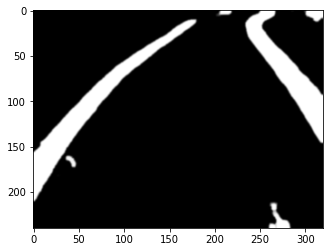

In [30]:
# preprocess the data to be used in the neural network
import cv2 as cv
import PIL
from keras.preprocessing.image import img_to_array

processedFrames = []

#loop through the images and filter green pixels
for i in range(len(frames)):
    blur = cv.GaussianBlur(frames[i], (35, 35), 0)
    # isolate green channel
    hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    # isolate green channel
    mask = cv.inRange(hsv, (10, 0, 40), (80, 255, 240))
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    mask = cv.GaussianBlur(mask, (5, 5), 0)
    # display the green channel
    # reduce the size of the image by a factor of 2
    # convert to array
    array = np.array(mask)
    # resize the array by 50%
    resized = cv.resize(array, (0, 0), fx=0.5, fy=0.5)
    # add the image to the end of the processedFrames array
    processedFrames.append(resized)
    
    

plt.imshow(processedFrames[0], cmap='gray')

In [31]:
from imgaug import augmenters as img_aug

# pan and zoom images and change brightness
seq = img_aug.Sequential([
    img_aug.Affine(rotate=(-20, 20), mode='edge'),
    img_aug.Affine(shear=(-16, 16), mode='edge'),
    img_aug.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, mode='edge'),
    img_aug.Affine(scale=(0.8, 1.2), mode='edge'),

])
# add more data to the processedFrames array
for i in range(0, 20000):
    random = np.random.randint(0, len(processedFrames))
    processedFrames.append(seq.augment_image(processedFrames[random]))
    steering.append(steering[random])

32284


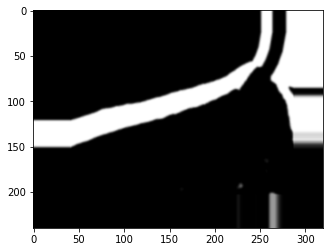

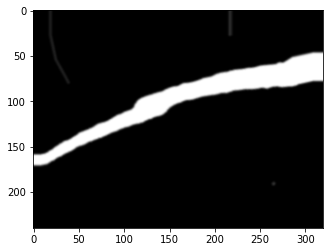

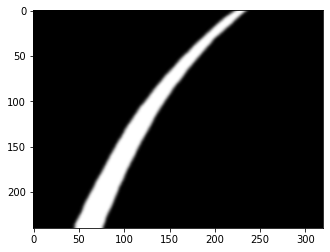

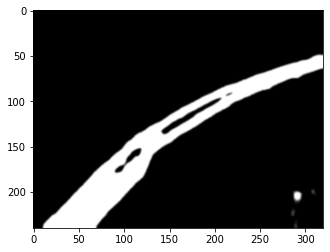

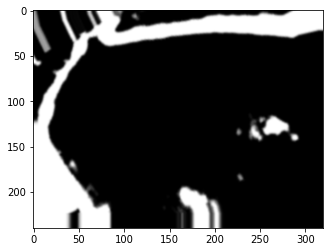

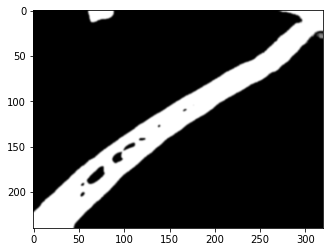

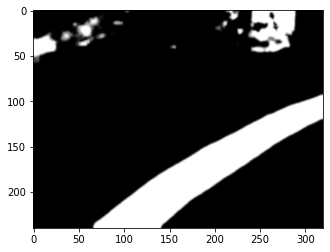

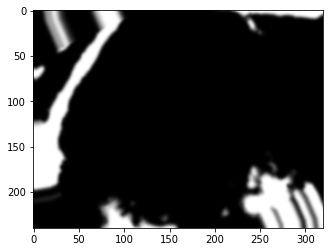

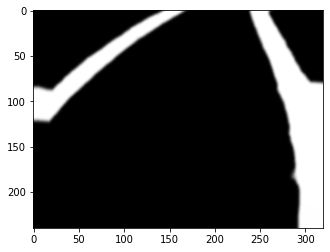

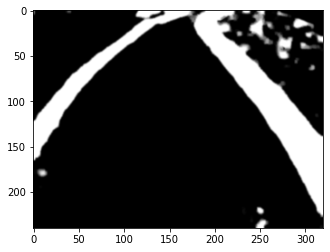

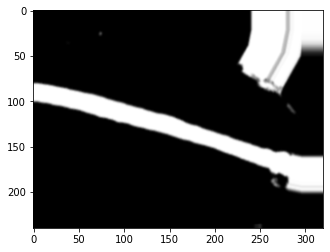

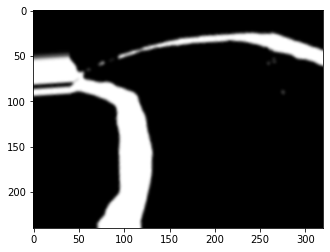

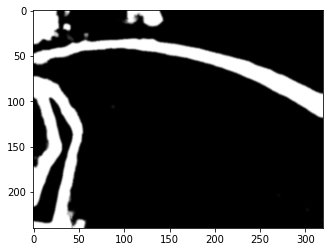

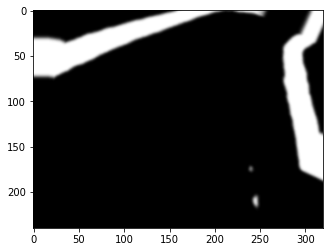

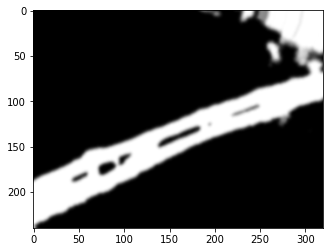

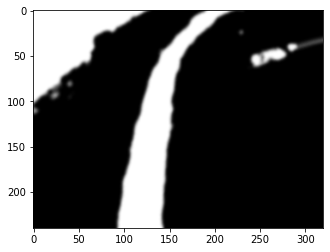

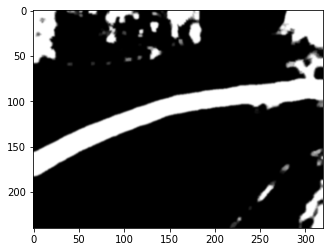

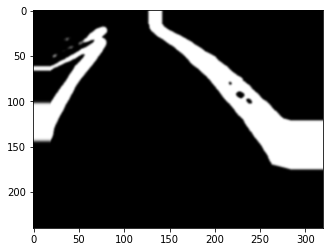

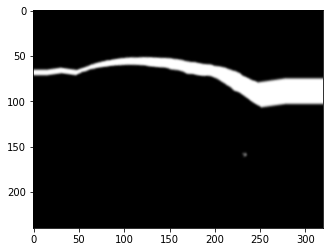

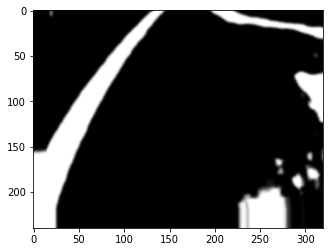

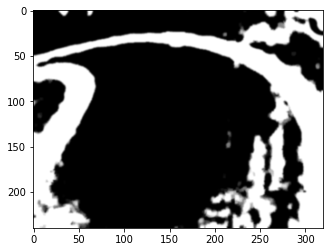

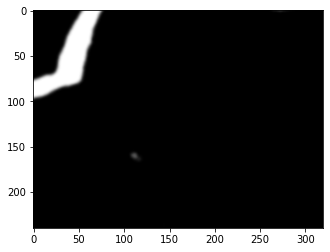

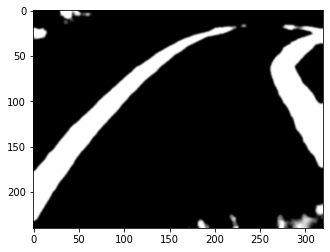

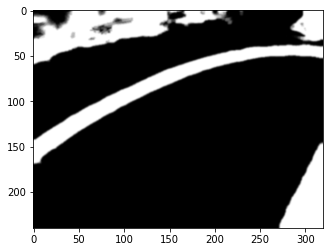

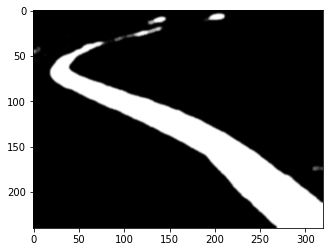

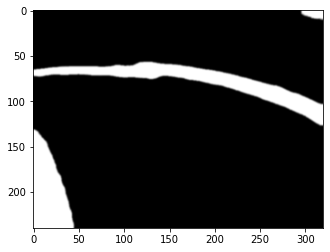

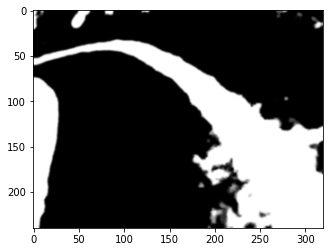

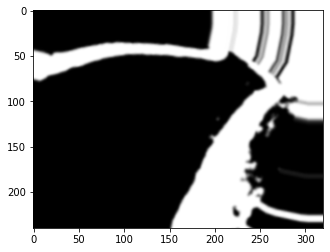

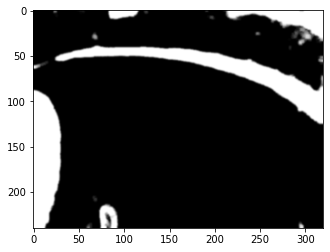

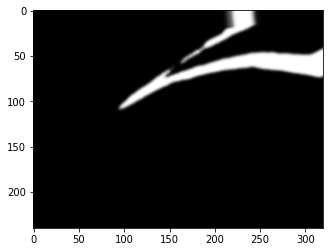

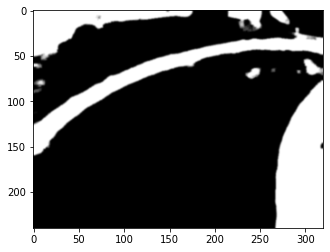

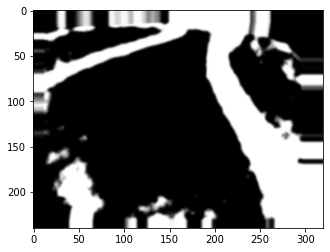

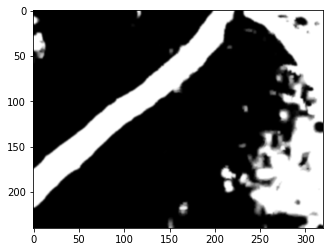

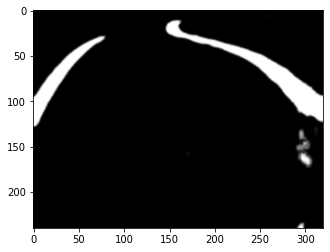

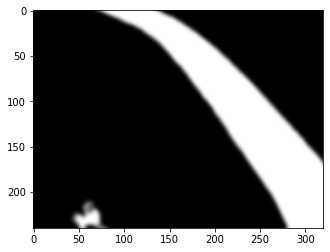

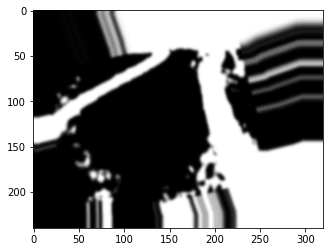

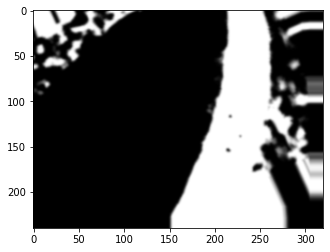

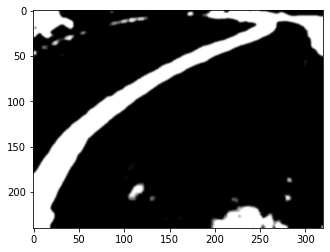

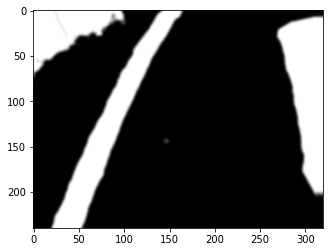

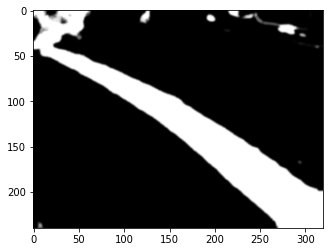

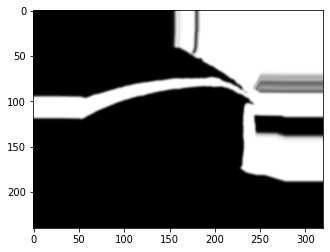

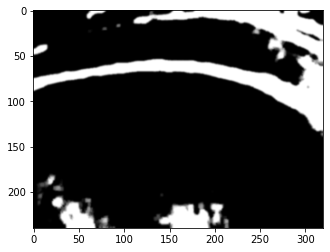

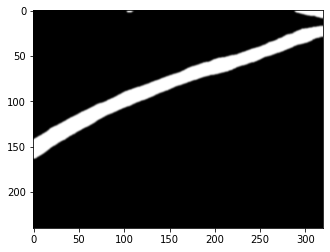

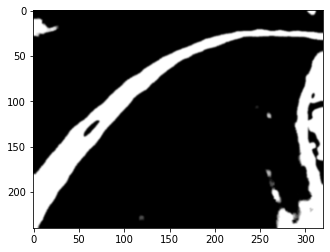

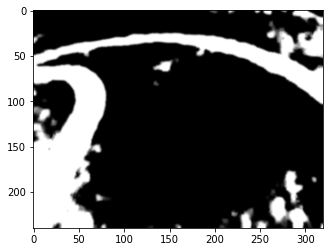

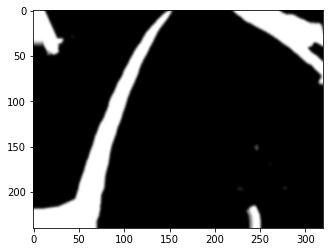

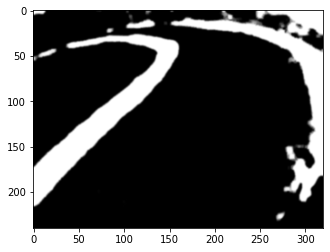

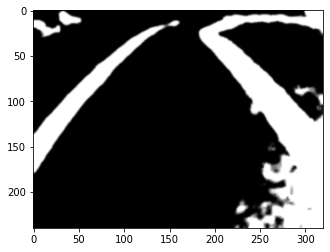

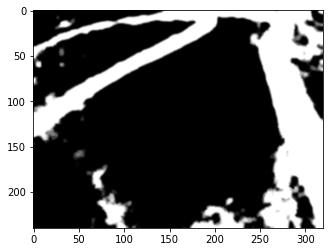

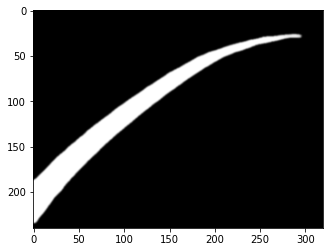

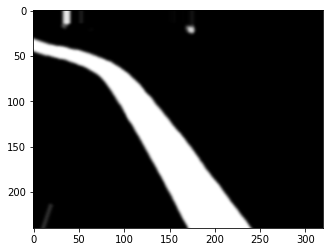

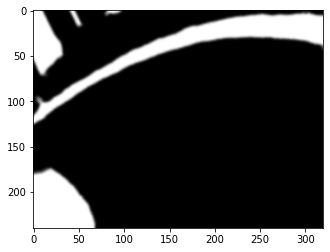

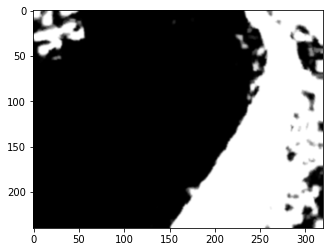

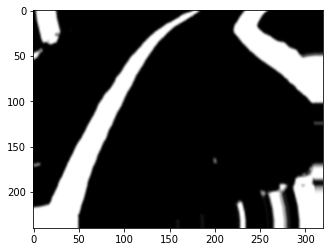

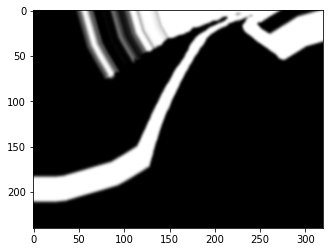

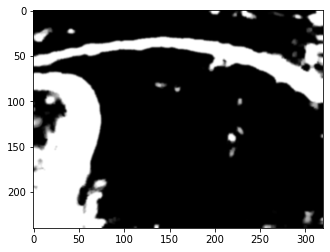

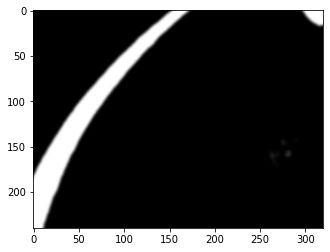

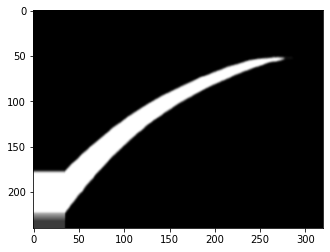

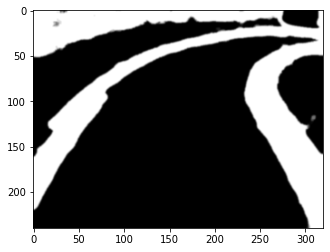

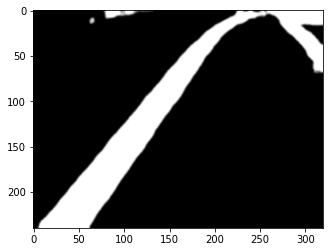

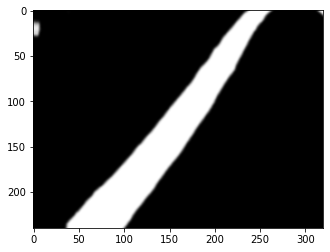

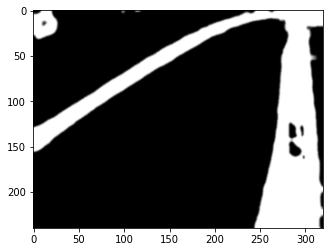

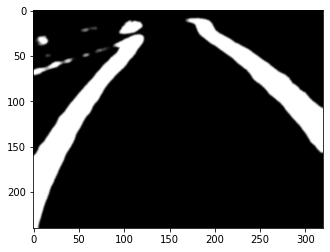

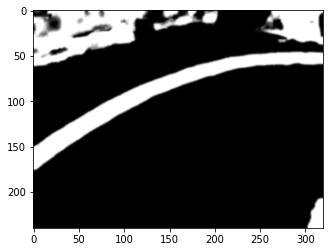

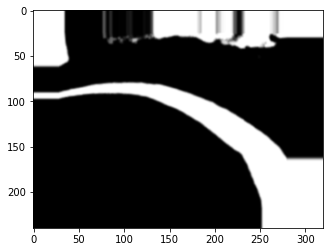

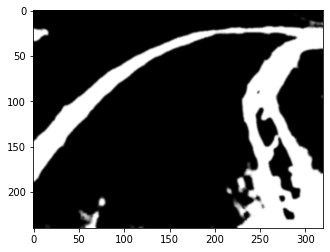

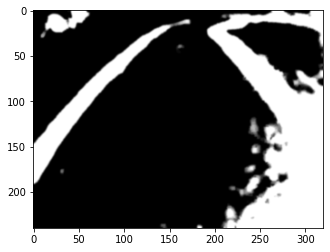

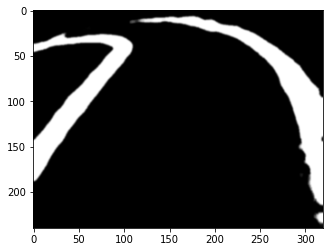

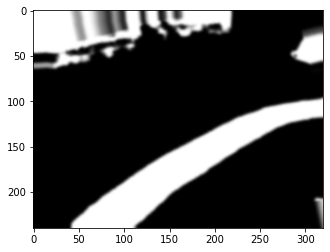

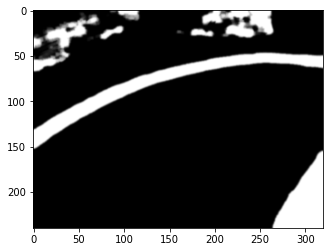

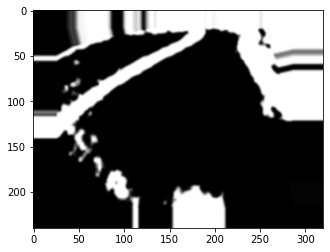

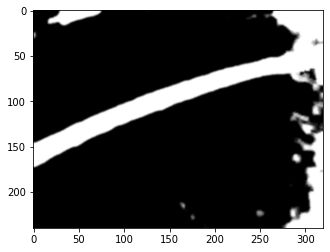

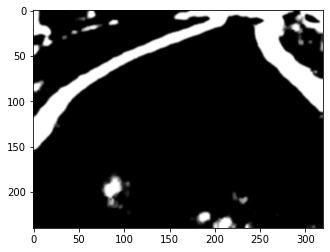

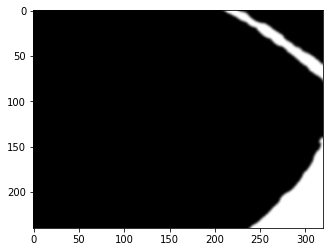

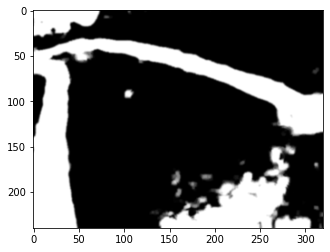

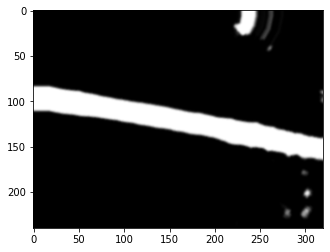

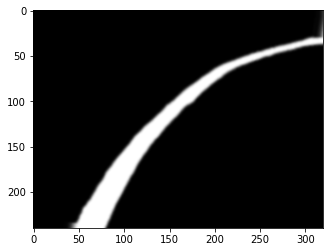

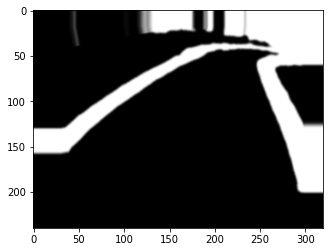

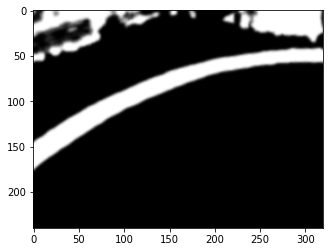

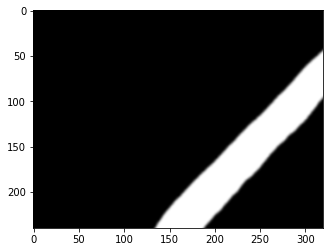

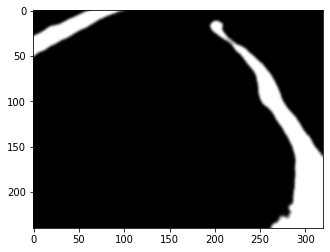

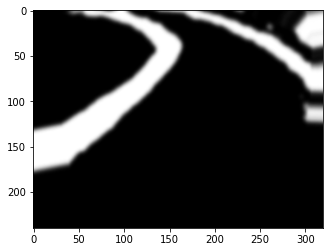

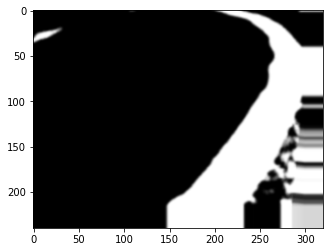

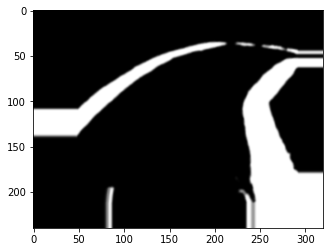

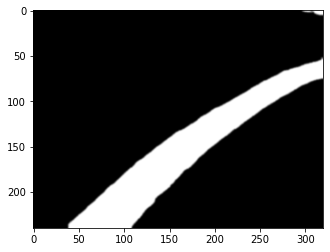

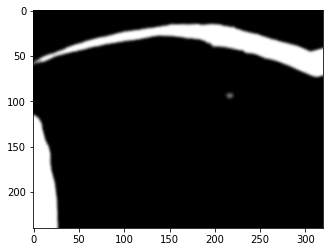

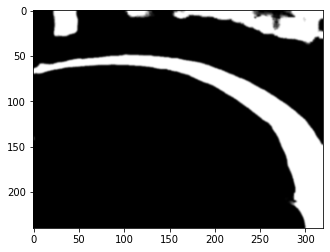

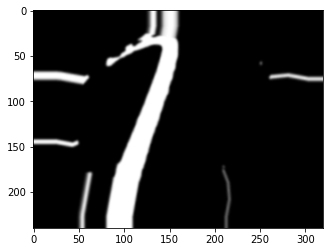

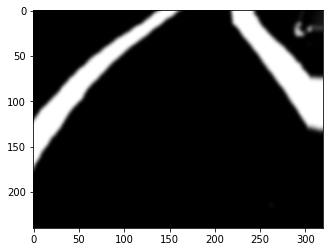

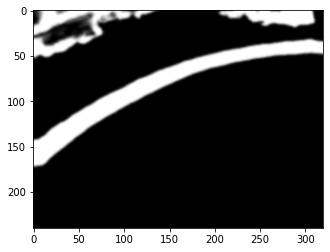

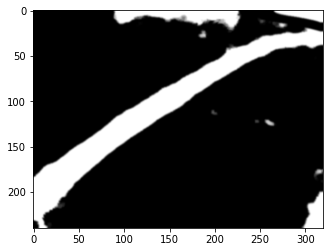

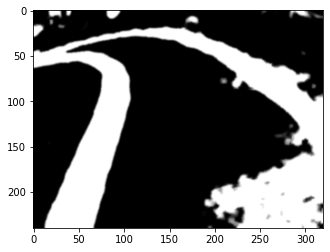

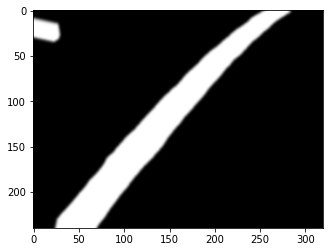

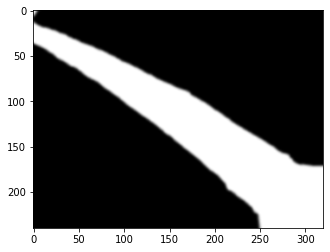

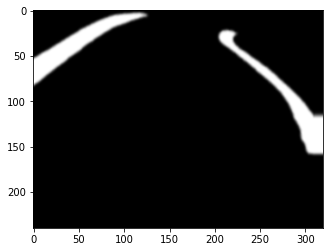

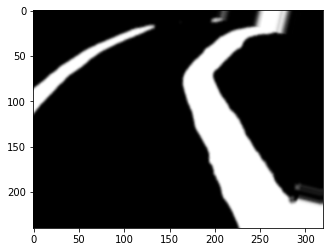

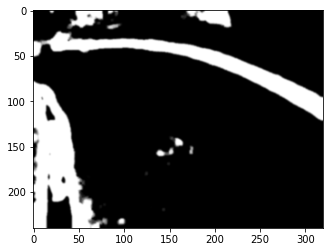

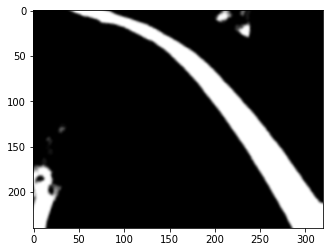

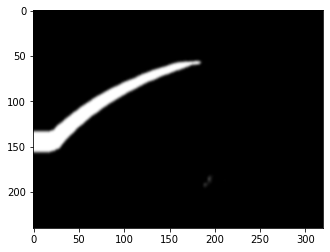

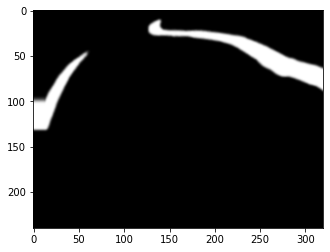

In [32]:
processedFrames = np.array(processedFrames)
print(len(processedFrames))

# shuffle the data the same 
from sklearn.utils import shuffle
processedFrames, steering = shuffle(processedFrames, steering, random_state=0)

for i in range(0, 100):
    plt.imshow(processedFrames[i], cmap='gray')
    plt.show()


In [33]:
# create a model with 3 convolutional layers and 1 fully connected layer
# that outputs a steering angle when given an image and steering data as input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from keras import backend as K
import time

K.clear_session()

print("Creating model")
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(240, 320, 1)))
model.add(Conv2D(24, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(36, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(48, (5, 5) , strides=(2,2) , activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(1000))
model.add(Dense(500))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(5))
model.add(Dense(1))


print('compiling model...')
# compile the model
model.compile(optimizer='adam', loss='mse')

print('fitting model...')
# train the model
model.fit(processedFrames, np.array(steering) , epochs=100, verbose=1, validation_split=0.3, shuffle=True, batch_size=64)

# graph the loss and accuracy
plt.plot(model.history.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

# print difference between the start and end loss
print(model.history.history['loss'][-1] - model.history.history['loss'][0])

#show what each layer looks like
model.summary()

#clear session
print('clearing session')
K.clear_session()



Creating model
compiling model...
fitting model...
Epoch 1/100


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/conv2d_1/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\arcxo\AppData\Local\Temp\ipykernel_11172\1957296210.py", line 37, in <module>
      model.fit(processedFrames, np.array(steering) , epochs=100, verbose=1, validation_split=0.3, shuffle=True, batch_size=64)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\arcxo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential/conv2d_1/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[64,32,238,318] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/conv2d_1/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1580]

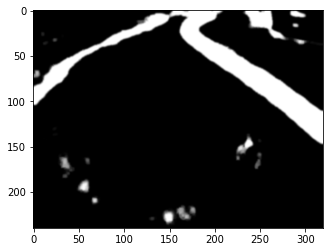

[[56.41972]]


In [16]:
frameNumber = 9
# grab the first image from the frames array
image = processedFrames[frameNumber]




# show the image and steering data
plt.imshow(image, cmap='gray')
plt.show()

# predict the steering angle for the first image
prediction = model.predict(image.reshape(1, 240, 320, 1))
print(prediction)

In [17]:
#save the model
model.save('atlas3.h5')

In [136]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [7]:
from numba import cuda
# clear session
print('clearing session')
cuda.select_device(0)
cuda.close()


clearing session
